<h1 style="text-align: center;">H04U1C - Optimization of Mechatronic Systems</h1>

Consider the two-link planar robot arm described in Chapter 8 of Modern Robotics (http://modernrobotics.org/). For additional background information, you can consult this book, section 8.1.

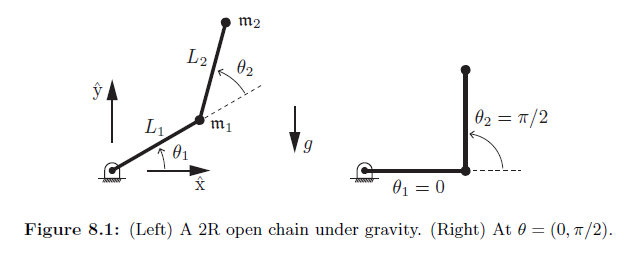

The equations of motion of this robot are given by: 

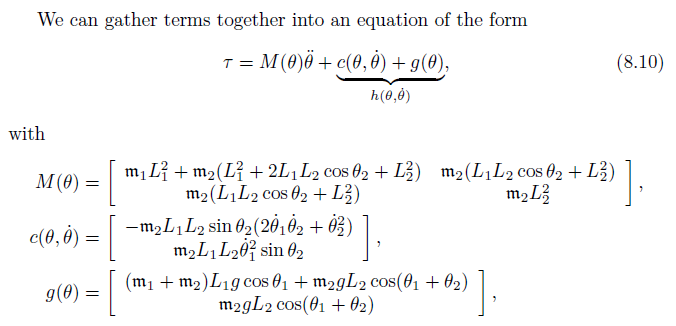

with:

* $\tau$: joint torques
* $\theta$: joint positions
* $m$: masses (assumed to be concentrated at the tip of the links)
* $L$: lengths.

Assume the following values: $L_1 = 0.5 \text{ m}$, $L_2 = 0.3 \text{ m}$, $m_1 = 3 \text{ kg}$, $m_2 = 1 \text{ kg}$.

Questions:

1. Write down the system dynamics equation for this robot in state-space form, such that we can use it in an optimal control problem, for the following two cases:

    a. case 1: assuming the robot is acceleration-controlled: the states are the joint positions $\theta$ and the joint velocities $\dot{\theta}$, and the controls are the desired joint accelerations $\ddot{\theta_r}$. You can assume that the acceleration controller is perfect, such that $\ddot{\theta_r} \equiv \ddot{\theta}$.
    
    b. case 2: assuming the robot is torque-controlled: the states are the joint positions $\theta$ and the joint velocities $\dot{\theta}$, and the controls are the desired joint torques $\tau_r$. You can assume that the torque controller is perfect, such that $\tau_r \equiv \tau$.

2. Formulate for both cases an optimal control problem that 

    a. minimizes the mean-square control effort (so mean-square joint acceleration for case 1, and mean-square joint torque for case 2), 
    
    b. moves the robot from initial joint positions $\theta_{\text{initial}} = [0.1, 0.5]^T \text{ rad}$ to terminal joint positions $\theta_{\text{terminal}} = [1.0, 1.9]^T \text{ rad}$ in $2$ seconds,

    c. starts and terminates with zero joint velocities, and

    d. the robot avoids self-collision.
    
    Implement and solve these two problems, and plot the resulting state and control trajectories.
    Are these two optimization problems convex or not? Briefly motivate your answer.

3. For case 1 (acceleration-controlled robot), formulate a time-optimal control problem that

    a. moves from initial joint positions $\theta_{\text{initial}} = [0.1, 0.5]^T \text{ rad}$ to terminal joint positions $\theta_{\text{terminal}} = [1.0, 1.9]^T \text{ rad}$ (in minimum time), and

    b. starts and terminates with zero joint velocities,

    c. satisfies the following control bounds: $-10 \text{ rad}/\text{s}^2 \leq \ddot{\theta_r} \leq 10 \text{ rad}/\text{s}^2$,

    d. the robot avoids self-collision, 

    e. the robot avoids collision with the ground (assume the ground is at $y = 0$).

    Is this problem convex or not? Briefly motivate your answer.
    Implement and solve this problem and plot the resulting state and control trajectories.

4. Write down the forward kinematics equation for this robot. This is the function $f$ such that $[x, y, \alpha]^T = f(\theta_1,\theta_2)$, with $x$, $y$ and $\alpha$ the pose (position and orientation) of the end effector ($m_2$).

5. For case 2 (torque-controlled robot), formulate an optimal control problem that

    a. minimizes the mean-square control effort (so the mean-square joint torques), and
    
    b. moves the robot from initial end effector pose $[0.8 \text{ m} , 0.0 \text{ m}, 0.0 \text{ rad}]^T$ to terminal end effector pose $[0.4 \text{ m} , 0.4 \text{ m}, 1.8 \text{ rad}]^T$ in $2$ seconds, and

    c. starts and terminates with zero joint velocities,

    d. the robot avoids self-collision, and

    e. the robot avoids collision with the ground (assume the ground is at $y = 0$).
    
    Implement and (try to) solve this problem. Do you get a solution? If yes, plot the resulting state and control trajectories. If not, explain what is problematic with the problem description, make a suggestion how we could modify the problem formulation and solve the modified problem.

The mean-square control effort for a system with control inputs $u(t)$ over a time horizon $[0,T]$ can be expressed as:

$ J = \frac{1}{T} \int_{0}^{T} \|u(t)\|^2 \ dt $

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      288
Number of nonzeros in inequality constraint Jacobian.:       22
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       64
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       48
Total number of inequality constraints...............:       22
        inequality constraints with only lower bounds:       11
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.74e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

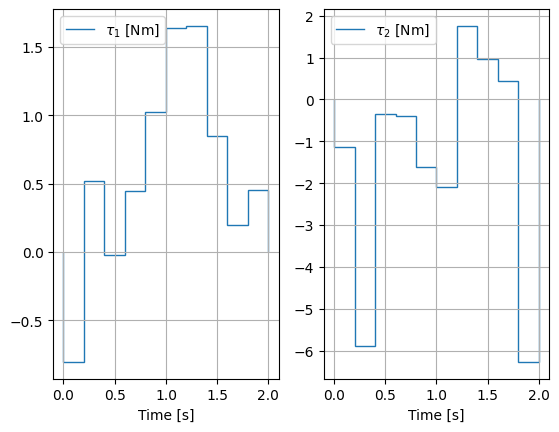

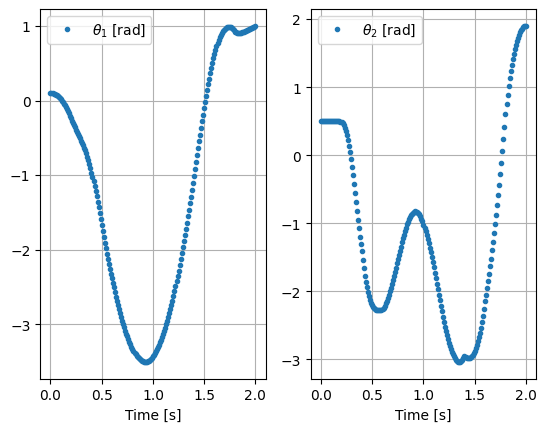

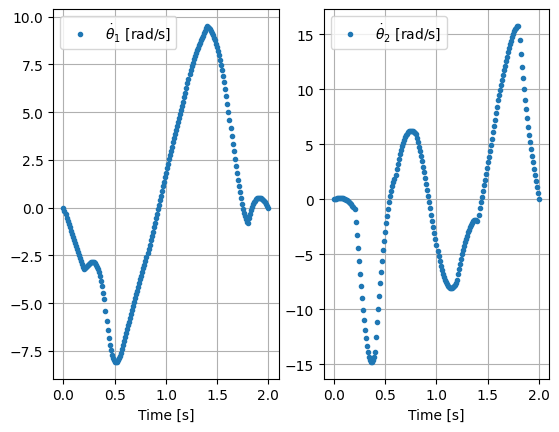

In [17]:
from rockit import *
from casadi import *
from numpy import *
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# Set the parameters
m1 = 3      # kg
m2 = 1      # kg
l1 = 0.5    # m
l2 = 0.3    # m

# Define the dynamics
def M(theta1, theta2):
    return vertcat(horzcat(m1*l1**2 + m2*(l1**2 + 2*l1*l2*cos(theta2) + l2**2), m2*(l1*l2*cos(theta2) + l2**2)),
                    horzcat(m2*(l1*l2*cos(theta2) + l2**2), m2*l2**2) )

def c(theta1, theta2, theta1_dot, theta2_dot):
    return vertcat(-m2*l1*l2*sin(theta2)*theta2_dot*(2*theta1_dot + theta2_dot),
                  m2*l1*l2*sin(theta2)*theta1_dot**2)

def g(theta1, theta2):
    return vertcat((m1 + m2)*l1*9.81*cos(theta1) + m2*l2*9.81*cos(theta1+theta2),
                  m2*l2*9.81*cos(theta1+theta2))

def f(theta1, theta2, theta1_dot, theta2_dot, torque1, torque2): # Returns \ddot{\theta} = M^(-1) * (torque - c - g) 
    M_ = M(theta1, theta2)
    c_ = c(theta1, theta2, theta1_dot, theta2_dot)
    g_ = g(theta1, theta2)
    return solve(M_, vertcat(torque1 - c_[0] - g_[0], torque2 - c_[1] - g_[1]))

ocp = Ocp(T=2.0) # Time horizon

# Define the states
theta1 = ocp.state()
theta2 = ocp.state()
theta1_dot = ocp.state()
theta2_dot = ocp.state()

# Defince controls
torque1 = ocp.control()
torque2 = ocp.control()

# Specify ODE
ocp.set_der(theta1, theta1_dot)
ocp.set_der(theta2, theta2_dot)
ocp.set_der(theta1_dot, f(theta1, theta2, theta1_dot, theta2_dot, torque1, torque2)[0])
ocp.set_der(theta2_dot, f(theta1, theta2, theta1_dot, theta2_dot, torque1, torque2)[1])

# Lagrange objective
obj = ocp.integral(torque1**2 + torque2**2) / 2
ocp.add_objective(obj)

# Motion constraints
epsilon = 1e-3
ocp.subject_to(theta2 <= pi - epsilon)  # Ensure theta2 is less than pi - epsilon
ocp.subject_to(theta2 >= -pi + epsilon)  # Ensure theta2 is greater than -pi + epsilon
# check if this is enough to avoid self-collision

# Initial constraints
ocp.subject_to(ocp.at_t0(theta1)==0.1)
ocp.subject_to(ocp.at_t0(theta2)==0.5)
ocp.subject_to(ocp.at_t0(theta1_dot)==0.)
ocp.subject_to(ocp.at_t0(theta2_dot)==0.)

# End constraints
ocp.subject_to(ocp.at_tf(theta1)==1.0)
ocp.subject_to(ocp.at_tf(theta2)==1.9)
ocp.subject_to(ocp.at_tf(theta1_dot)==0.)
ocp.subject_to(ocp.at_tf(theta2_dot)==0.)

# Pick a solver
ocp.solver('ipopt')

# Pick a solution method
ocp.method(MultipleShooting(N=10, M=1, intg='rk'))

# Solve the OCP
sol = ocp.solve()

# Plot the solution
t_u1, torque1_sol = sol.sample(torque1, grid='control')
t_u2, torque2_sol = sol.sample(torque2, grid='control')
t_x1, theta1_sol = sol.sample(theta1,  grid='integrator', refine=20)
t_x2, theta2_sol = sol.sample(theta2,  grid='integrator', refine=20)
t_x3, theta1_dot_sol = sol.sample(theta1_dot,  grid='integrator', refine=20)
t_x4, theta2_dot_sol = sol.sample(theta2_dot,  grid='integrator', refine=20)

plt.figure()
plt.subplot(1, 2, 1)
plt.stairs(torque1_sol[:-1], t_u1, label=r'$\tau_1$ [Nm]')
plt.xlabel("Time [s]")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.stairs(torque2_sol[:-1], t_u2, label=r'$\tau_2$ [Nm]')
plt.xlabel("Time [s]")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(t_x1, theta1_sol, '.', label=r'$\theta_1$ [rad]')
plt.xlabel("Time [s]")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_x2, theta2_sol, '.', label=r'$\theta_2$ [rad]')
plt.xlabel("Time [s]")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(t_x3, theta1_dot_sol, '.', label=r'$\dot{\theta}_1$ [rad/s]')
plt.xlabel("Time [s]")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_x4, theta2_dot_sol, '.', label=r'$\dot{\theta}_2$ [rad/s]')
plt.xlabel("Time [s]")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def create_animation(sol):
    # Plot the solution
    t_u1, torque1_sol = sol.sample(torque1, grid='integrator', refine=50)
    t_u2, torque2_sol = sol.sample(torque2, grid='integrator', refine=50)
    t_x1, theta1_sol = sol.sample(theta1,  grid='integrator', refine=50)
    t_x2, theta2_sol = sol.sample(theta2,  grid='integrator', refine=50)
    t_x3, theta1_dot_sol = sol.sample(theta1_dot,  grid='integrator', refine=50)
    t_x4, theta2_dot_sol = sol.sample(theta2_dot,  grid='integrator', refine=50)

    # Calculate the positions of the joints and end effector
    x1 = l1 * np.cos(theta1_sol)
    y1 = l1 * np.sin(theta1_sol)
    x2 = x1 + l2 * np.cos(theta1_sol + theta2_sol)
    y2 = y1 + l2 * np.sin(theta1_sol + theta2_sol)
    time = t_x1

    # Create a figure and axis for the animation
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))

    # Set limits and labels for the robot arm plot
    axs[0, 0].set_xlim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
    axs[0, 0].set_ylim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
    axs[0, 0].set_aspect('equal')
    axs[0, 0].set_title('Robot Arm Movement')
    axs[0, 0].set_xlabel('X [m]')
    axs[0, 0].set_ylabel('Y [m]')
    axs[0, 0].grid(True)
    line1, = axs[0, 0].plot([], [], 'o-', lw=2, label='Link 1')
    line2, = axs[0, 0].plot([], [], 'o-', lw=2, label='Link 2')

    # Initialize the points for the states and inputs
    theta1_points, = axs[1, 0].plot([], [], 'b.', label=r'$\theta_1$ [rad]')
    theta2_points, = axs[1, 1].plot([], [], 'r.', label=r'$\theta_2$ [rad]')
    theta1_dot_points, = axs[2, 0].plot([], [], 'b.', label=r'$\dot{\theta}_1$ [rad/s]')
    theta2_dot_points, = axs[2, 1].plot([], [], 'r.', label=r'$\dot{\theta}_2$ [rad/s]')
    torque1_points, = axs[3, 0].plot([], [], 'b.', label=r'$\tau_1$ [Nm]')
    torque2_points, = axs[3, 1].plot([], [], 'r.', label=r'$\tau_2$ [Nm]')

    # Set titles and labels for the plots
    axs[0, 1].axis('off')
    #axs[1, 0].set_title('Joint Angles')
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    #axs[1, 1].set_title('Joint Angles')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    #axs[2, 0].set_title('Joint Velocities')
    axs[2, 0].legend()
    axs[2, 0].grid(True)
    #axs[2, 1].set_title('Joint Velocities')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    #axs[3, 0].set_title('Joint Torques')
    axs[3, 0].set_xlabel('Time [s]')
    axs[3, 0].legend()
    axs[3, 0].grid(True)
    #axs[3, 1].set_title('Joint Torques')
    axs[3, 1].set_xlabel('Time [s]')
    axs[3, 1].legend()
    axs[3, 1].grid(True)

    # Initialize the animation
    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        theta1_points.set_data([], [])
        theta2_points.set_data([], [])
        theta1_dot_points.set_data([], [])
        theta2_dot_points.set_data([], [])
        torque1_points.set_data([], [])
        torque2_points.set_data([], [])
        return line1, line2, theta1_points, theta2_points, theta1_dot_points, theta2_dot_points, torque1_points, torque2_points

    a = np.ones(len(time))
    b = np.ones(len(time))

    # Update function for the animation
    def update(frame):
        line1.set_data([0, x1[frame]], [0, y1[frame]])
        line2.set_data([x1[frame], x2[frame]], [y1[frame], y2[frame]])
        theta1_points.set_data(time[:frame], theta1_sol[:frame])
        theta2_points.set_data(time[:frame], theta2_sol[:frame])
        theta1_dot_points.set_data(time[:frame], theta1_dot_sol[:frame])
        theta2_dot_points.set_data(time[:frame], theta2_dot_sol[:frame])
        torque1_points.set_data(time[:frame], torque1_sol[:frame])
        torque2_points.set_data(time[:frame], torque2_sol[:frame])

        # Autoscale the axes
        axs[1, 0].relim()
        axs[1, 0].autoscale_view()
        axs[1, 1].relim()
        axs[1, 1].autoscale_view()
        axs[2, 0].relim()
        axs[2, 0].autoscale_view()
        axs[2, 1].relim()
        axs[2, 1].autoscale_view()
        axs[3, 0].relim()
        axs[3, 0].autoscale_view()
        axs[3, 1].relim()
        axs[3, 1].autoscale_view()

        return line1, line2, theta1_points, theta2_points, theta1_dot_points, theta2_dot_points, torque1_points, torque2_points

    # Create the animation
    animation = FuncAnimation(fig, update, frames=len(time), init_func=init, blit=True, interval=20, repeat_delay=2000)
    animation.save('robot_arm_animation.gif')

create_animation(sol)

MovieWriter ffmpeg unavailable; using Pillow instead.
